# 相关训练过程

1. 读取数据集

In [2]:
import pandas as pd

ratings = pd.read_csv(
    "../datasets/ml-1m/ratings.dat",
    sep="::",
    engine="python",
    names=['userId', 'movieId', 'rating', 'timestamp']
)
movies = pd.read_csv(
    "../datasets/ml-1m/movies.dat",
    sep="::",
    engine="python",
    names=['movieId', 'title', 'genres']
)
df = pd.merge(ratings, movies[['movieId', 'title']], on='movieId')


2. 使用留出法制作训练集和测试集

In [3]:
import pandas as pd
import numpy as np

def split_low_memory(df, test_ratio=0.1, min_items=5, seed=42):
    rng = np.random.default_rng(seed)
    test_indices = []

    for uid, group in df.groupby("userId"):
        if len(group) < min_items:
            continue

        test_size = max(1, int(len(group) * test_ratio))
        chosen = rng.choice(group.index, size=test_size, replace=False)
        test_indices.extend(chosen)

    test_indices = set(test_indices)
    mask = df.index.isin(test_indices)
    return df[~mask], df[mask]

def split_by_time(df, test_ratio=0.1, min_items=5):
    """
    按时间序列划分：对每个用户，按 timestamp 排序，
    最后的 test_ratio 部分作为测试集，其余作为训练集。
    """
    test_indices = []

    for uid, group in df.groupby("userId"):
        if len(group) < min_items:
            continue

        group_sorted = group.sort_values("timestamp")
        test_size = max(1, int(len(group_sorted) * test_ratio))
        chosen = group_sorted.tail(test_size).index
        test_indices.extend(chosen)

    test_indices = set(test_indices)
    mask = df.index.isin(test_indices)
    return df[~mask], df[mask]

train_df, test_df = split_by_time(df)
print("train:", len(train_df), "test:", len(test_df))

train: 902826 test: 97383


回收df，减少内存占用

In [4]:
import gc
del df

gc.collect()

26

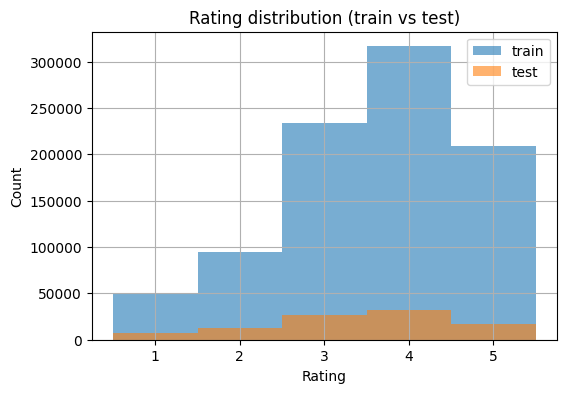

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
train_df["rating"].hist(bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], alpha=0.6, label="train")
test_df["rating"].hist(bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], alpha=0.6, label="test")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating distribution (train vs test)")
plt.legend()
plt.show()


3. 建立训练集的稀疏矩阵，同时将测试集转换为（用户，电影，评分）元组的列表

In [ ]:
from scipy.sparse import csr_matrix
import pandas as pd


def build_train_test(train_df, test_df):
    # category 创建映射
    user_cat = train_df["userId"].astype("category")
    movie_cat = train_df["movieId"].astype("category")

    u_train = user_cat.cat.codes.values
    m_train = movie_cat.cat.codes.values
    r_train = train_df["rating"].values

    user_categories = user_cat.cat.categories
    movie_categories = movie_cat.cat.categories

    # 测试集映射到训练集空间
    u_test = pd.Categorical(test_df["userId"], user_categories).codes
    m_test = pd.Categorical(test_df["movieId"], movie_categories).codes
    r_test = test_df["rating"].values

    # 过滤掉 -1（训练集没出现）
    mask = (u_test != -1) & (m_test != -1)
    test_tuples = list(zip(u_test[mask], m_test[mask], r_test[mask]))

    mat = csr_matrix((r_train, (u_train, m_train)), shape=(len(user_categories), len(movie_categories)))

    return mat, test_tuples
train_sparse, test_tuples = build_train_test(train_df, test_df)
print("train sparse shape:", train_sparse.shape)
print("test tuples:", len(test_tuples))

train sparse shape: (6040, 3683)
test tuples: 97353


4. 将训练集进行svd分解防止在后续训练过程中爆内存

In [7]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD


def build_user_vectors(train_mat,dim=128):
    svd = TruncatedSVD(n_components=dim, random_state=42)
    X = svd.fit_transform(train_mat.astype("float32"))
    X = normalize(X, axis=1)
    return X

def build_item_vectors(train_mat,dim=128):
    svd = TruncatedSVD(n_components=dim, random_state=42)
    X = svd.fit_transform(train_mat.T.astype("float32"))
    X = normalize(X, axis=1)
    return X

train_user_vectors = build_user_vectors(train_sparse)
train_item_vectors = build_item_vectors(train_sparse)
print("train user vectors shape:", train_user_vectors.shape)
print("train item vectors shape:", train_item_vectors.shape)

train user vectors shape: (6040, 128)
train item vectors shape: (3683, 128)


5. 通过计算用户之间的余弦相似度,进而聚合用户，然后利用相似用户评分的均值得到预测评分

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def predict_rating(user_vectors, train_mat, user_id, movie_id, k=20):
    user_vector = user_vectors[user_id].reshape(1, -1)
    sim = cosine_similarity(user_vector, user_vectors).flatten()

    # 排除自己
    sim[user_id] = -1

    # 取前 k 个相似用户
    top_k_users = np.argpartition(sim, -k)[-k:]
    top_k_sims = sim[top_k_users]

    # 计算加权平均评分
    ratings = train_mat[top_k_users, movie_id].toarray().flatten()
    mask = ratings > 0
    if np.sum(mask) == 0:
        return 0.0  # 没有相似用户评分，返回默认值

    weighted_ratings = ratings[mask] * top_k_sims[mask]
    prediction = np.sum(weighted_ratings) / np.sum(top_k_sims[mask])
    return prediction

# 测试预测
user_id, movie_id, true_rating = test_tuples[0]
pred_rating = predict_rating(train_user_vectors, train_sparse, user_id, movie_id, k=20)
print(f"User {user_id}, Movie {movie_id}, True Rating: {true_rating}, Predicted Rating: {pred_rating:.2f}")

User 0, Movie 47, True Rating: 5, Predicted Rating: 2.75


In [9]:
import time
import inspect
from functools import wraps


def calculate_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # 解析实参，拿到 pred_func（如果有）
        sig = inspect.signature(func)
        bound = sig.bind_partial(*args, **kwargs)
        pred = bound.arguments.get("pred_func", None)
        if pred is not None and pred.__name__ == "<lambda>":
            function_name = "ann"
        elif pred is None:
            function_name = "pred_rating_by_user_cf"
        else:
            function_name = pred.__name__

        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()

        if pred is not None:
            print(f"{func.__name__} (pred_func={function_name}) took {end - start:.4f} seconds")
        else:
            print(f"{func.__name__} took {end - start:.4f} seconds")
        return result

    return wrapper


6. 计算通过余弦相似度进行预测的准确率

evaluate took 2.3772 seconds
Evaluation Accuracy: 0.3800


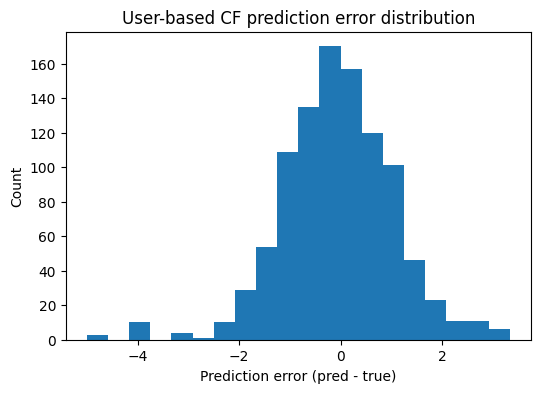

In [10]:
@calculate_time
def evaluate(user_vectors, test_tuples, top_k=10, pred_func=predict_rating):
    hits = 0
    total = len(test_tuples)
    errors = []

    for user_id, movie_id, true_rating in test_tuples:
        pred_rating = pred_func(user_vectors, train_sparse, user_id, movie_id, k=top_k)
        errors.append(pred_rating - true_rating)
        if abs(pred_rating - true_rating) < 0.5:
            hits += 1

    accuracy = hits / total if total > 0 else 0
    return accuracy, errors

accuracy, errors = evaluate(train_user_vectors, test_tuples[:1000], top_k=100)
print(f"Evaluation Accuracy: {accuracy:.4f}")
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=20)
plt.xlabel("Prediction error (pred - true)")
plt.ylabel("Count")
plt.title("User-based CF prediction error distribution")
plt.show()

7. 计算通过余弦相似度进行预测的均方根误差

In [11]:
@calculate_time
def rmse(user_vectors, test_tuples, k=100, pred_func=predict_rating):
    squared_errors = []

    for user_id, movie_id, true_rating in test_tuples:
        pred_rating = pred_func(user_vectors, train_sparse, user_id, movie_id, k=k)
        squared_errors.append((pred_rating - true_rating) ** 2)

    mse = np.mean(squared_errors)
    return np.sqrt(mse)
rmse_value = rmse(train_user_vectors, test_tuples[:1000], k=100)
print(f"RMSE: {rmse_value:.4f}")

rmse took 2.4762 seconds
RMSE: 1.1183


8. 基于物品的协同过滤

User 0, Movie 47, True Rating: 5, Predicted Rating: 4.11
evaluate (pred_func=predict_rating_byitem) took 1.6936 seconds
Evaluation Accuracy (Item-based): 0.3930
rmse (pred_func=predict_rating_byitem) took 1.5875 seconds
RMSE (Item-based): 1.0733


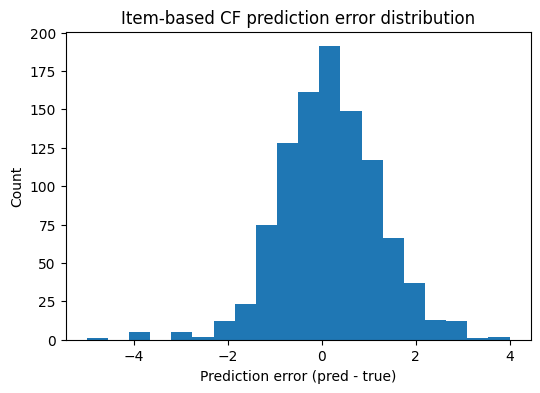

In [ ]:
def predict_rating_byitem(item_vectors, train_mat, user_id, movie_id, k=20):
    item_vector = item_vectors[movie_id].reshape(1, -1)
    sim = cosine_similarity(item_vector, item_vectors).flatten()

    # 排除自己
    sim[movie_id] = -1

    # 取前 k 个相似物品
    top_k_items = np.argpartition(sim, -k)[-k:]
    top_k_sims = sim[top_k_items]

    # 计算加权平均评分
    ratings = train_mat[user_id, top_k_items].toarray().flatten()
    mask = ratings > 0
    if np.sum(mask) == 0:
        return 0.0  # 没有相似物品评分，返回默认值

    weighted_ratings = ratings[mask] * top_k_sims[mask]
    prediction = np.sum(weighted_ratings) / np.sum(top_k_sims[mask])
    return prediction

# 测试预测
user_id, movie_id, true_rating = test_tuples[0]
predicted_rating = predict_rating_byitem(train_item_vectors, train_sparse, user_id, movie_id, k=100)
print(f"User {user_id}, Movie {movie_id}, True Rating: {true_rating}, Predicted Rating: {predicted_rating:.2f}")
accuracy, errors = evaluate(train_item_vectors, test_tuples[:1000], top_k=100, pred_func=predict_rating_byitem)
print(f"Evaluation Accuracy (Item-based): {accuracy:.4f}")
rmse_value = rmse(train_item_vectors, test_tuples[:1000], k=100, pred_func=predict_rating_byitem)
print(f"RMSE (Item-based): {rmse_value:.4f}")
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=20)
plt.xlabel("Prediction error (pred - true)")
plt.ylabel("Count")
plt.title("Item-based CF prediction error distribution")
plt.show()

9. 建立hnsw进行查询时需要的索引

In [ ]:
import hnswlib





ANN index built.


8. 基于用户的协同过滤使用hnsw进行优化

User 0, Movie 47, True Rating: 5, Predicted Rating: 3.23
evaluate (pred_func=ann) took 0.2293 seconds
Evaluation Accuracy (ANN-based): 0.3820
rmse (pred_func=ann) took 0.2423 seconds
RMSE (ANN-based): 1.1186


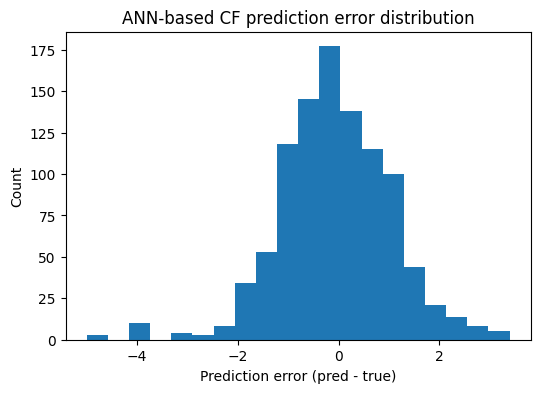

In [ ]:
def build_ann_index(X, ef=200, M=128):
    dim = X.shape[1]
    num_users = X.shape[0]
    index = hnswlib.Index(space="cosine", dim=dim)
    index.init_index(max_elements=num_users, ef_construction=ef, M=M)
    index.add_items(X)
    index.set_ef(ef)
    return index

def get_similar_users(ann_index, user_vector, k=20):
    labels, distances = ann_index.knn_query(user_vector, k=k)
    # cosine 距离 ∈ [0, 2]，相似度 = 1 - distance
    sims = 1 - distances[0]
    users = labels[0]
    return users, sims

def predict_rating_ann(ann_index, user_vectors, train_mat, user_id, movie_id, k=20):
    user_vector = user_vectors[user_id].reshape(1, -1)
    top_k_users, top_k_sims = get_similar_users(ann_index, user_vector, k=k)

    # 排除自己
    mask = top_k_users != user_id
    top_k_users = top_k_users[mask]
    top_k_sims = top_k_sims[mask]

    # 计算加权平均评分
    ratings = train_mat[top_k_users, movie_id].toarray().flatten()
    mask = ratings > 0
    if np.sum(mask) == 0:
        return 0.0

    weighted_ratings = ratings[mask] * top_k_sims[mask]
    prediction = np.sum(weighted_ratings) / np.sum(top_k_sims[mask])
    return prediction

ann_index = build_ann_index(train_user_vectors)

print("ANN index built.")

# 测试预测
user_id, movie_id, true_rating = test_tuples[0]
predicted_rating = predict_rating_ann(ann_index, train_user_vectors, train_sparse, user_id, movie_id, k=100)
print(f"User {user_id}, Movie {movie_id}, True Rating: {true_rating}, Predicted Rating: {predicted_rating:.2f}")
accuracy, errors = evaluate(
    train_user_vectors,
    test_tuples[:1000],
    top_k=100,
    pred_func=lambda uv, tm, uid, mid, k: predict_rating_ann(ann_index, uv, tm, uid, mid, k),
)
print(f"Evaluation Accuracy (ANN-based): {accuracy:.4f}")
rmse_value = rmse(
    train_user_vectors,
    test_tuples[:1000],
    k=100,
    pred_func=lambda uv, tm, uid, mid, k: predict_rating_ann(ann_index, uv, tm, uid, mid, k),
)
print(f"RMSE (ANN-based): {rmse_value:.4f}")
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=20)
plt.xlabel("Prediction error (pred - true)")
plt.ylabel("Count")
plt.title("ANN-based CF prediction error distribution")
plt.show()

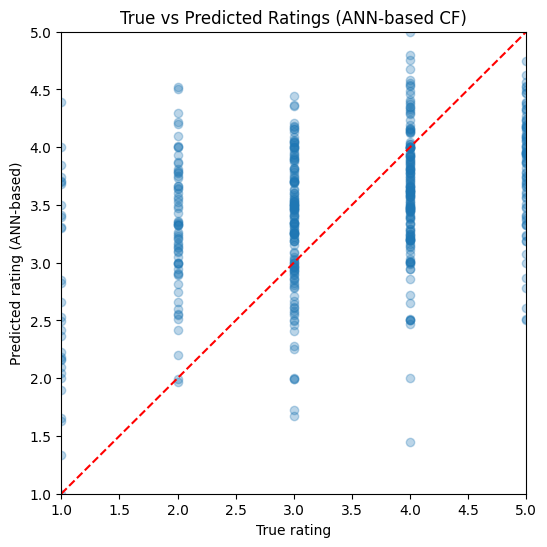

In [15]:
true_vals = []
pred_vals = []

for user_id, movie_id, true_rating in test_tuples[:500]:
    pred = predict_rating_ann(ann_index, train_user_vectors, train_sparse, user_id, movie_id, k=100)
    true_vals.append(true_rating)
    pred_vals.append(pred)

plt.figure(figsize=(6, 6))
plt.scatter(true_vals, pred_vals, alpha=0.3)
plt.plot([1, 5], [1, 5], "r--")  # 对角线
plt.xlabel("True rating")
plt.ylabel("Predicted rating (ANN-based)")
plt.title("True vs Predicted Ratings (ANN-based CF)")
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.show()


9. 对三种方法计算得到的准确率进行对比分析（这里可以看到三者的准确率是差不多的，但是使用ANN优化后速度要快不少）

evaluate took 2.4604 seconds
rmse took 2.4225 seconds
evaluate (pred_func=predict_rating_byitem) took 1.6524 seconds
rmse (pred_func=predict_rating_byitem) took 1.6492 seconds
evaluate (pred_func=ann) took 0.2227 seconds
rmse (pred_func=ann) took 0.2181 seconds


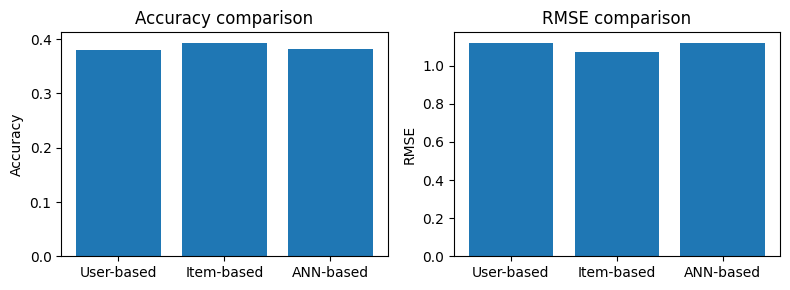

In [16]:
methods = ["User-based", "Item-based", "ANN-based"]

acc_user, _ = evaluate(train_user_vectors, test_tuples[:1000], top_k=100)
rmse_user = rmse(train_user_vectors, test_tuples[:1000], k=100)

acc_item, _ = evaluate(train_item_vectors, test_tuples[:1000], top_k=100, pred_func=predict_rating_byitem)
rmse_item = rmse(train_item_vectors, test_tuples[:1000], k=100, pred_func=predict_rating_byitem)

acc_ann, _ = evaluate(
    train_user_vectors,
    test_tuples[:1000],
    top_k=100,
    pred_func=lambda uv, tm, uid, mid, k: predict_rating_ann(ann_index, uv, tm, uid, mid, k),
)
rmse_ann = rmse(
    train_user_vectors,
    test_tuples[:1000],
    k=100,
    pred_func=lambda uv, tm, uid, mid, k: predict_rating_ann(ann_index, uv, tm, uid, mid, k),
)

accuracies = [acc_user, acc_item, acc_ann]
rmses = [rmse_user, rmse_item, rmse_ann]

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.bar(methods, accuracies)
plt.ylabel("Accuracy")
plt.title("Accuracy comparison")

plt.subplot(1, 2, 2)
plt.bar(methods, rmses)
plt.ylabel("RMSE")
plt.title("RMSE comparison")
plt.tight_layout()
plt.show()


9. 计算用户对所有没看过的电影（针对训练集而言）的评分，并得到其中的topk个电影

In [17]:
def recommend_topk(train_mat, user, Krec=50):
    user_vector = train_user_vectors[user].reshape(1, -1)
    top_k_users, top_k_sims = get_similar_users(ann_index, user_vector, k=100)
    watched_set = set(train_mat[user].nonzero()[1])

    score_dict = {}
    for similar_user, sim in zip(top_k_users, top_k_sims):
        user_ratings = train_mat[similar_user].toarray().flatten()
        for movie_id, rating in enumerate(user_ratings):
            if rating > 0 and movie_id not in watched_set:
                if movie_id not in score_dict:
                    score_dict[movie_id] = 0.0
                score_dict[movie_id] += rating * sim

    ranked_movies = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)
    topk = [movie_id for movie_id, score in ranked_movies[:Krec]]
    return topk

topk = recommend_topk(train_sparse, user=0, Krec=10)
print("Top-K recommendations for user 0:", topk)

Top-K recommendations for user 0: [353, 1890, 1100, 308, 1114, 33, 1102, 1184, 2190, 1889]


10. 进行召回率的计算（这里召回率表示在预测喜欢的电影占用户真正喜欢电影的比例（具体指在5393部电影上选50部模型认为用户喜欢的电影并且用户真正喜欢的/5393部电影中用户真正喜欢的电影））

In [18]:
def recall_at_k(train_mat, test_tuples, Krec=50, like_threshold=4.0):
    # 组织测试集：user → [(movie, rating)]
    test_map = {}
    for u, m, r in test_tuples:
        test_map.setdefault(u, []).append((m, r))

    sum_recall = 0
    cnt_user = 0

    for u, pairs in test_map.items():
        # 用户在测试集中真正喜欢的电影
        liked = [m for m, r in pairs if r >= like_threshold]
        if not liked:
            continue  # 没有喜欢电影就跳过，不影响指标

        rec_list = recommend_topk(train_mat, user=u, Krec=Krec)

        hit = sum(1 for m in liked if m in rec_list)
        recall = hit / len(liked)

        sum_recall += recall
        cnt_user += 1

    return sum_recall / cnt_user

def sampled_recall_at_k(
    user_vectors,
    test_tuples,
    top_k=10,
    n_neg=50,
    like_threshold=4.0,
    pred_func=predict_rating,
    seed=42,
):
    rng = np.random.default_rng(seed)
    num_items = train_sparse.shape[1]

    hits = 0
    total = 0

    for user_id, pos_item, rating in test_tuples:
        if rating < like_threshold:
            continue

        neg_items = set()
        while len(neg_items) < n_neg:
            j = int(rng.integers(0, num_items))
            if j != pos_item:
                neg_items.add(j)

        candidates = [pos_item] + list(neg_items)
        scores = []
        for item in candidates:
            s = pred_func(user_vectors, train_sparse, user_id, item, k=top_k)
            scores.append(s)
        scores = np.array(scores)

        k = min(top_k, len(candidates))
        topk_idx = np.argpartition(-scores, k - 1)[:k]

        if 0 in topk_idx:
            hits += 1
        total += 1

    return hits / total if total > 0 else 0.0


# topk_recall = recall_at_k(train_sparse, test_tuples, Krec=50, like_threshold=4.0)
# print("Top-K Recall@50:", topk_recall)
print(len(test_tuples))
rec_sampled = sampled_recall_at_k(train_user_vectors, test_tuples[:1000], top_k=10, n_neg=50)
print("Sampled Recall@10 (user-CF):", rec_sampled)

97353
Sampled Recall@10 (user-CF): 0.6827309236947792


In [19]:
def sampled_recall_ndcg_at_k(
    user_vectors,
    test_tuples,
    top_k=10,
    n_neg=50,
    like_threshold=4.0,
    pred_func=predict_rating,
    seed=42,
):
    rng = np.random.default_rng(seed)
    num_items = train_sparse.shape[1]

    hits = 0
    dcg_sum = 0.0
    total = 0

    for user_id, pos_item, rating in test_tuples:
        if rating < like_threshold:
            continue

        # 采样负样本
        neg_items = set()
        while len(neg_items) < n_neg:
            j = int(rng.integers(0, num_items))
            if j != pos_item:
                neg_items.add(j)

        candidates = [pos_item] + list(neg_items)  # 0 号是正样本
        scores = []
        for item in candidates:
            s = pred_func(user_vectors, train_sparse, user_id, item, k=top_k)
            scores.append(s)
        scores = np.array(scores)

        k = min(top_k, len(candidates))
        # top-k 命中 (sampled recall@k)
        topk_idx = np.argpartition(-scores, k - 1)[:k]
        if 0 in topk_idx:
            hits += 1

        # nDCG@k：算正样本的排名
        order = np.argsort(-scores)  # 从大到小
        pos_rank = int(np.where(order == 0)[0][0])  # 0-based
        if pos_rank < k:
            dcg_sum += 1.0 / np.log2(pos_rank + 2)  # rank+2 对应 1-based +1

        total += 1

    if total == 0:
        return 0.0, 0.0

    recall = hits / total
    ndcg = dcg_sum / total
    return recall, ndcg


In [20]:
def build_next_test_tuples(train_df, test_df):
    # 重新构建与 train_sparse 一致的用户/物品编号
    user_cat = train_df["userId"].astype("category")
    movie_cat = train_df["movieId"].astype("category")
    user_categories = user_cat.cat.categories
    movie_categories = movie_cat.cat.categories

    next_rows = test_df.sort_values("timestamp").groupby("userId", as_index=False).first()

    next_test_tuples = []
    for _, row in next_rows.iterrows():
        uid = row["userId"]
        mid = row["movieId"]
        rating = row["rating"]

        # 映射到 0-based 索引（要能在训练矩阵里找到）
        if uid not in user_categories or mid not in movie_categories:
            continue
        u_idx = user_categories.get_loc(uid)
        m_idx = movie_categories.get_loc(mid)
        next_test_tuples.append((u_idx, m_idx, rating))

    return next_test_tuples
next_test_tuples = build_next_test_tuples(train_df, test_df)
print("Next test tuples:", len(next_test_tuples))

Next test tuples: 6039


In [33]:
rec_sampled = sampled_recall_at_k(
    train_user_vectors,
    next_test_tuples,
    top_k=10,
    n_neg=50,
)
print("Sampled Recall@10 (user-CF, next-item):", rec_sampled)


Sampled Recall@10 (user-CF, next-item): 0.8198757763975155


In [34]:
rec_sampled = sampled_recall_at_k(
    train_user_vectors,
    next_test_tuples,
    top_k=50,
    n_neg=500,
    pred_func=lambda uv, tm, uid, mid, k: predict_rating_ann(ann_index, uv, tm, uid, mid, k)
)
print("Sampled Recall@50 (user-CF, next-item):", rec_sampled)

Sampled Recall@50 (user-CF, next-item): 0.43365330321852064


In [22]:
rec_sampled, ndcg_sampled = sampled_recall_ndcg_at_k(
    train_user_vectors,
    next_test_tuples,
    top_k=50,
    n_neg=500,
    pred_func=lambda uv, tm, uid, mid, k: predict_rating_ann(ann_index, uv, tm, uid, mid, k)
)
print("Sampled Recall@50 (ann, next-item):", rec_sampled)
print("Sampled NDCG@50 (ann, next-item):", ndcg_sampled)

Sampled Recall@50 (ann, next-item): 0.43365330321852064
Sampled NDCG@50 (ann, next-item): 0.10468651627389783
